In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from metavision_core.event_io import RawReader, EventsIterator
from metavision_ml.preprocessing import histo

In [2]:
%matplotlib inline

Constants

In [3]:
MAX_EVENTS = 1_000_000_000

In [4]:
paths = {e.lower().replace('.raw', '') : f'../data/raw/{e}' for e in os.listdir('../data/raw') if '.raw' in e}
print(*sorted(paths.keys()))

a1 a2 a3 a4 b1 b2 b3 b4


Data loading functions

In [5]:
def _get_n_events(rawreader):
    rawreader.reset()
    while not rawreader.done:
        rawreader.seek_event(MAX_EVENTS // 100)
    n_events = rawreader.current_event_index()
    rawreader.reset()
    return n_events

def read_file_raw(fpath):
    rawreader = RawReader(fpath, max_events=MAX_EVENTS)
    n_events = _get_n_events(rawreader)
    events = rawreader.load_n_events(n_events)
    assert events.shape[0] < MAX_EVENTS, 'too many events in file'
    return events

def read_file_chunk(fpath, delta_t, t_start):
    rawreader = RawReader(fpath)
    rawreader.seek_time(t_start)
    events = rawreader.load_delta_t(delta_t)
    return events

def read_file_chunk_idx(fpath, delta_t, idx):
    rawreader = RawReader(fpath)
    rawreader.seek_time(delta_t * idx)
    events = rawreader.load_delta_t(delta_t)
    return events

Plotting functions

In [6]:
def plot_event_count(file, delta_t, t_start, n_bins):
    x_1s = read_file_chunk(fpath=file, delta_t=delta_t, t_start=t_start)
    print(f'{x_1s.shape[0]:,} events')
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,4), dpi=200)
    fig.suptitle(f'event count over time ($t_{{total}}=${delta_t:,.0f}µs, ' + \
                 f'$t_{{bin}}=${delta_t/n_bins:,.0f}µs, $t_{{start}}$={t_start/1e6:,.0f}s)')
    ax.hist(x_1s['t'], bins=n_bins, rwidth=0.9);

In [7]:
def histogram_for_file(fpath):
    xypt = read_file_raw(fpath)
    hist = np.zeros((1, 2, 480, 640))
    histo(xypt, hist, total_tbins_delta_t=xypt['t'].max())
    return hist

def plot_histogram_for_file(fpath, pol=0, ax=None):
    hist = histogram_for_file(fpath)
    if ax is None:
        _, ax = plt.subplots()
    ax.imshow(hist[0,pol,:,:])
    return hist

def plot_histogram(hist, pol=0, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.set_title(f'pol={pol}')
    ax.imshow(hist[0,pol,:,:])

In [8]:
def plot_hists(hists, title=None):
    """Plots the histograms in `hists` along the x-axis, with polarity on the y-axis."""
    NCOLS = len(hists)
    fig, axs = plt.subplots(ncols=NCOLS, nrows=2, sharex=True, sharey=True, figsize=(10,4), dpi=200)
    for idx in range(NCOLS):
        for pol in range(2):
            if pol == 0:
                axs[pol][idx].set_title(f'{idx}')
            if idx == 0:
                axs[pol][idx].set_ylabel(f'pol={pol}')
            axs[pol][idx].imshow(hists[idx][0,pol,:,:])
            axs[pol][idx].set_yticks([])
            axs[pol][idx].set_xticks([])
    if title:
        fig.suptitle(title)
    plt.tight_layout()

Testing the data loading

In [9]:
read_file_raw('../data/raw/A1.raw').shape

(220781207,)

In [10]:
(lambda x: (x.shape, x[0].shape))(np.load('data/compressed/A1.npy', allow_pickle=True))

((6112,), (15206,))

## Visualizations

358,613 events


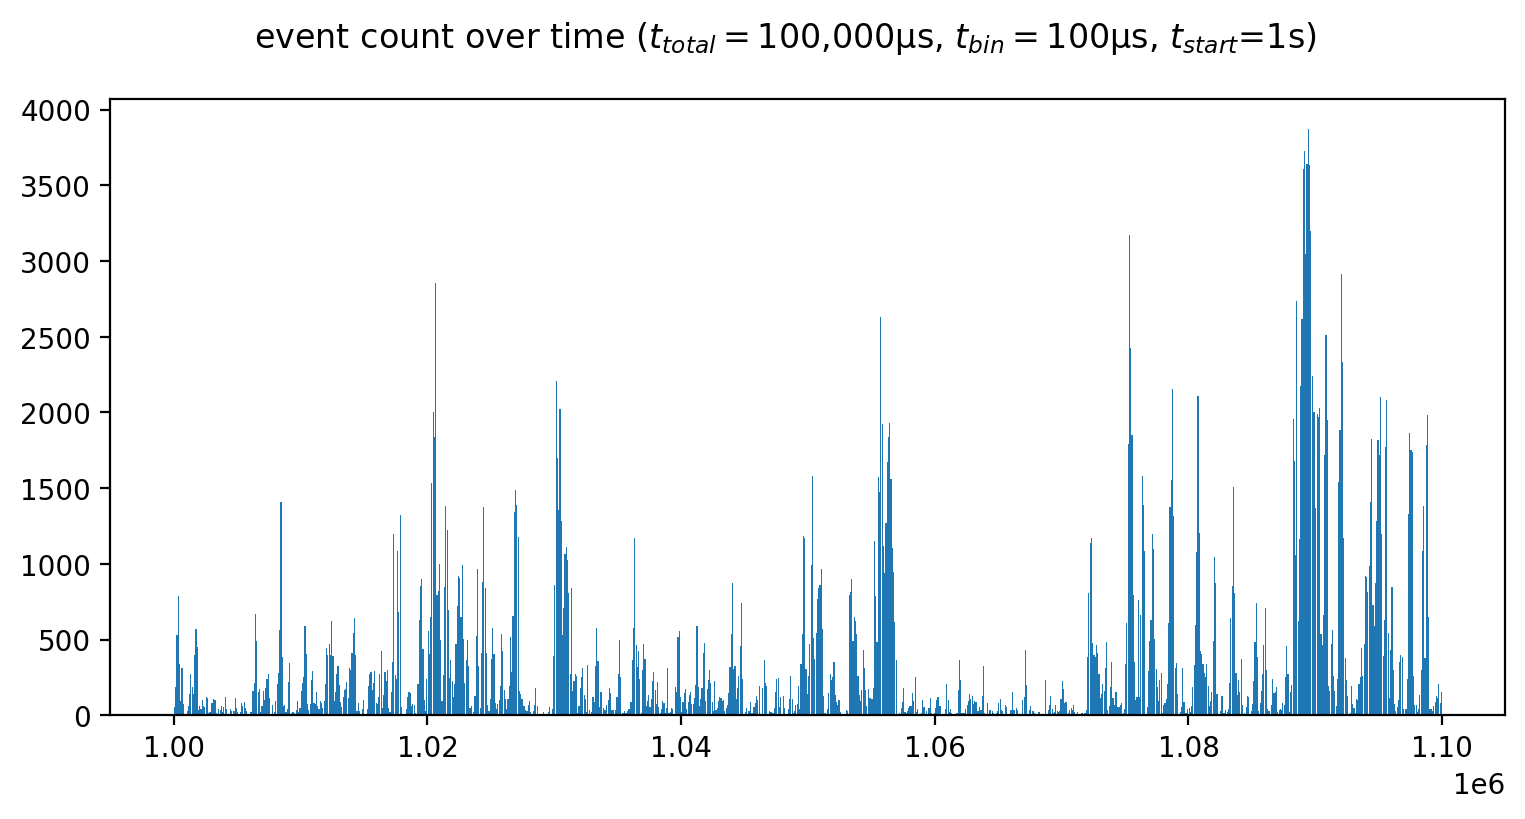

In [11]:
plot_event_count(paths['a1'], t_start=1_000_000, delta_t=100_000, n_bins=1_000)

375,487 events


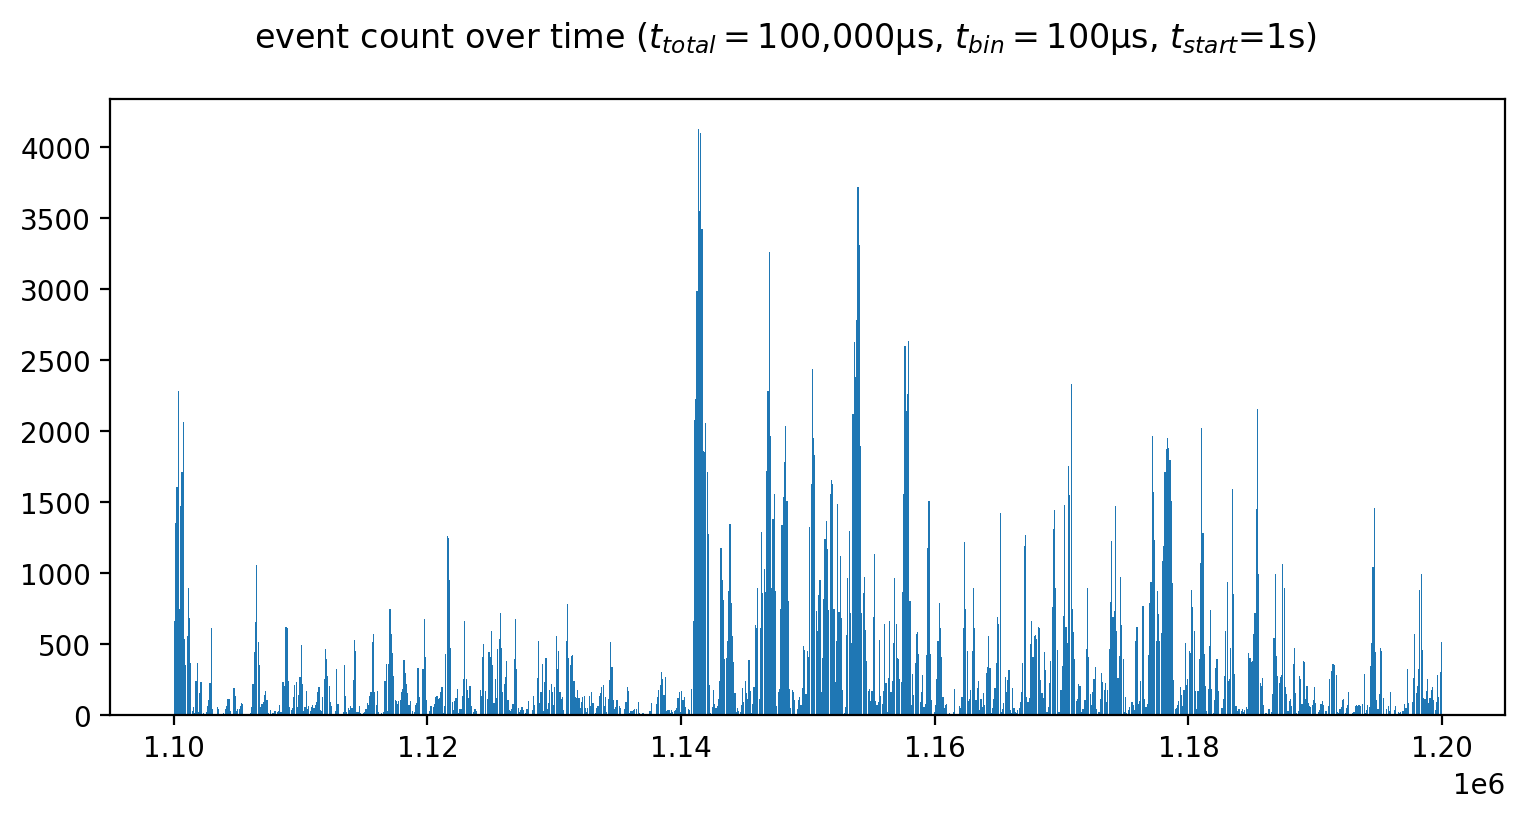

In [12]:
plot_event_count(paths['a1'], t_start=1_100_000, delta_t=100_000, n_bins=1_000)

Another trial

484,141 events


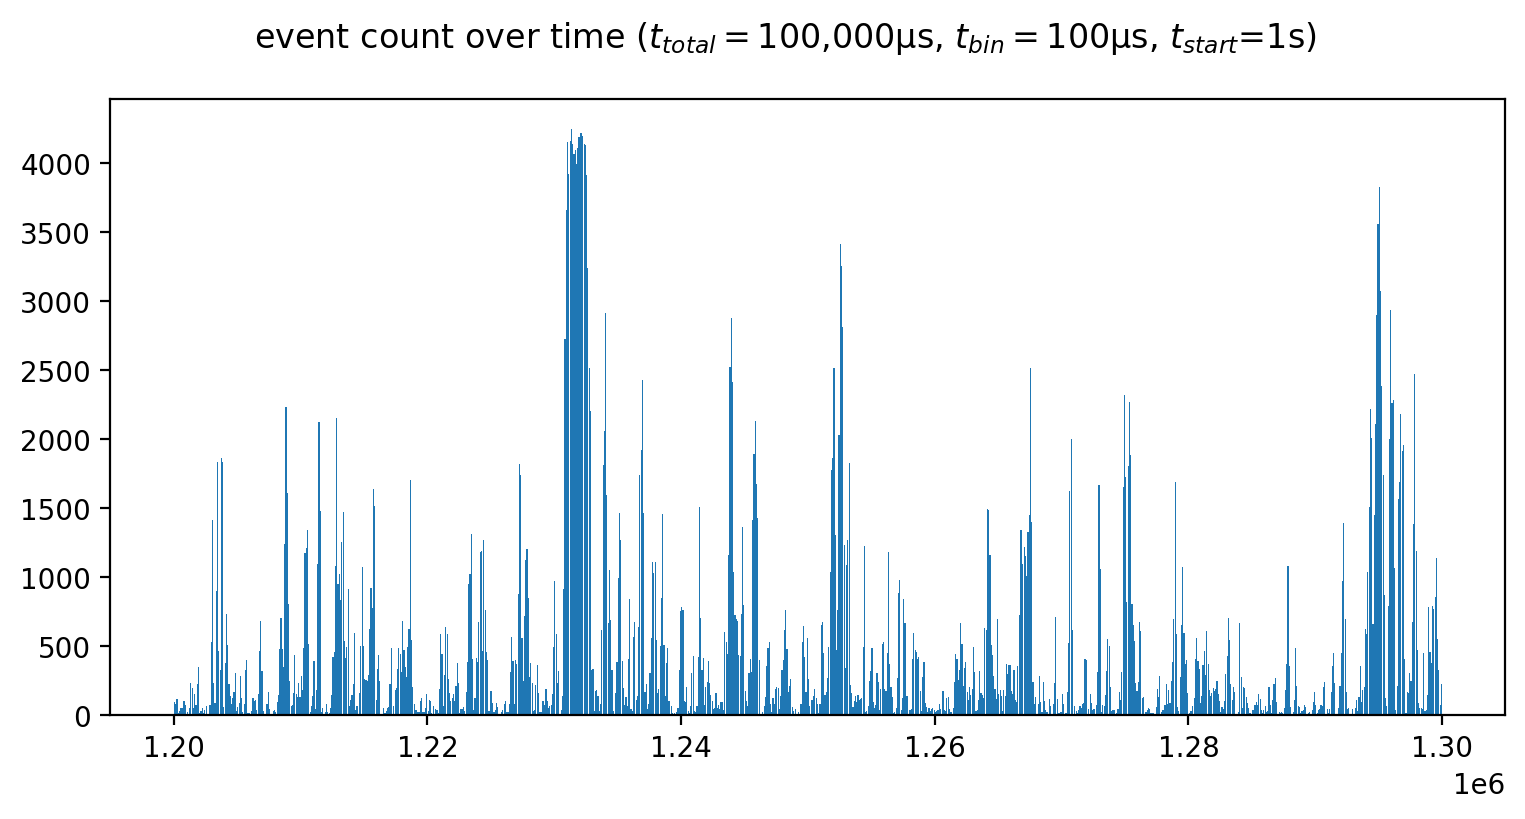

In [13]:
plot_event_count(paths['a3'], t_start=1_200_000, delta_t=100_000, n_bins=1_000)

Another class

482,726 events


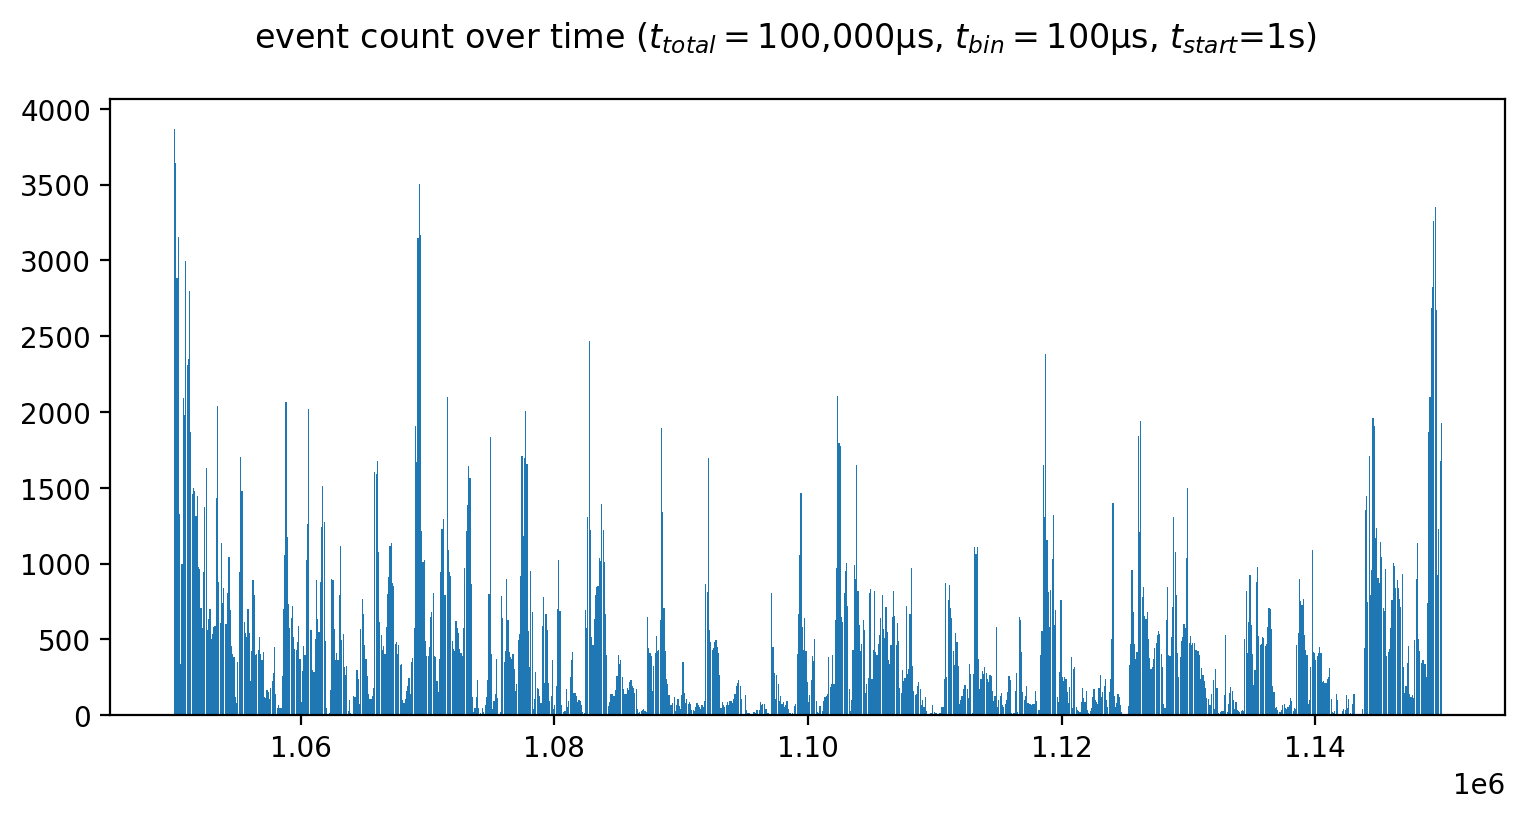

In [14]:
plot_event_count(paths['b1'], t_start=1_050_000, delta_t=100_000, n_bins=1_000)

482,726 events


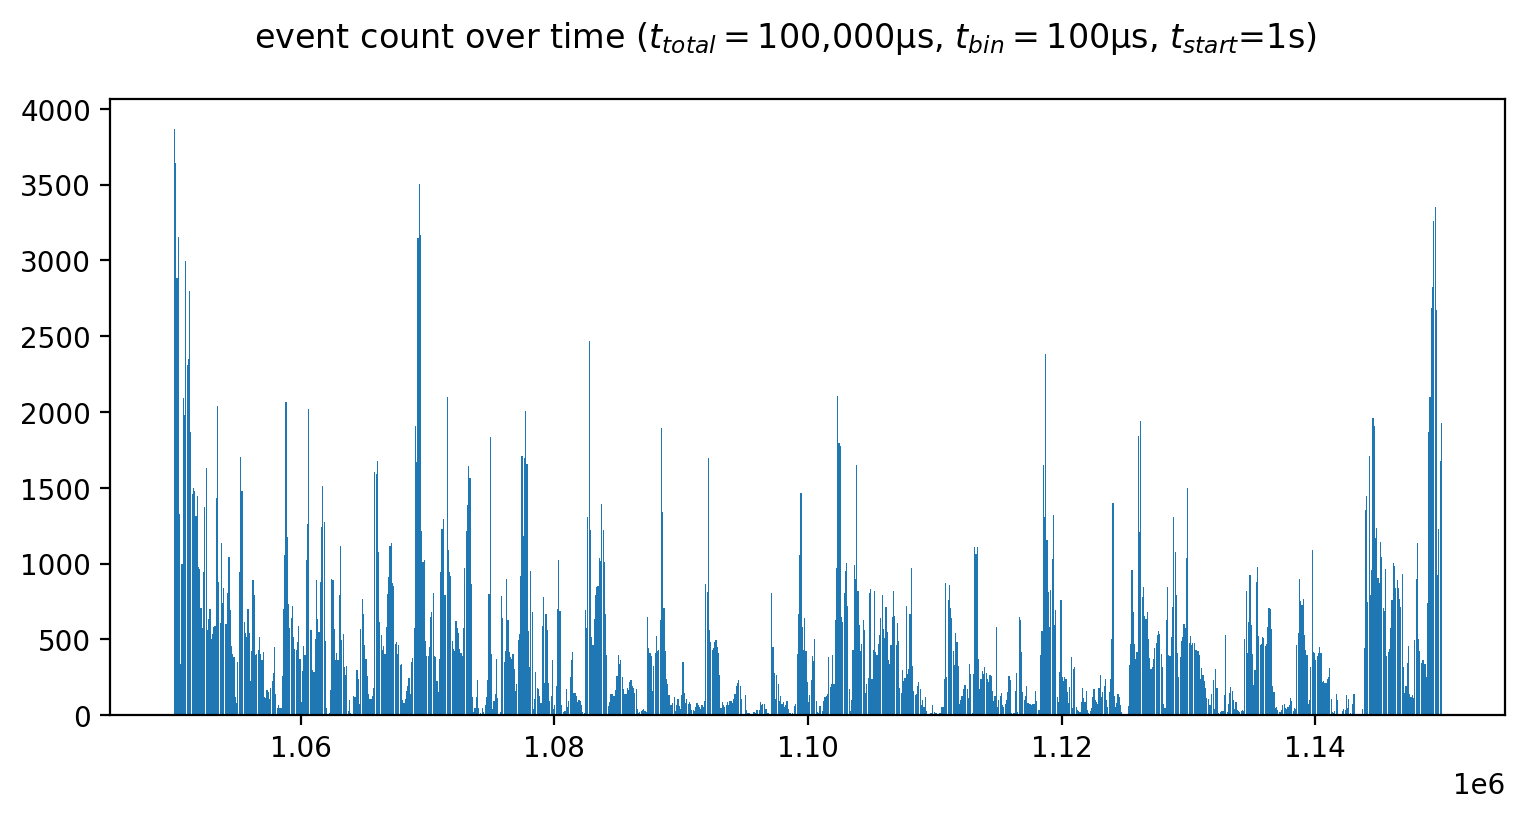

In [15]:
plot_event_count(paths['b1'], t_start=1_050_000, delta_t=100_000, n_bins=1_000)

## Histograms

Of the whole trial

In [16]:
a1 = read_file_raw(paths['a1'])
a1.shape

(220781207,)

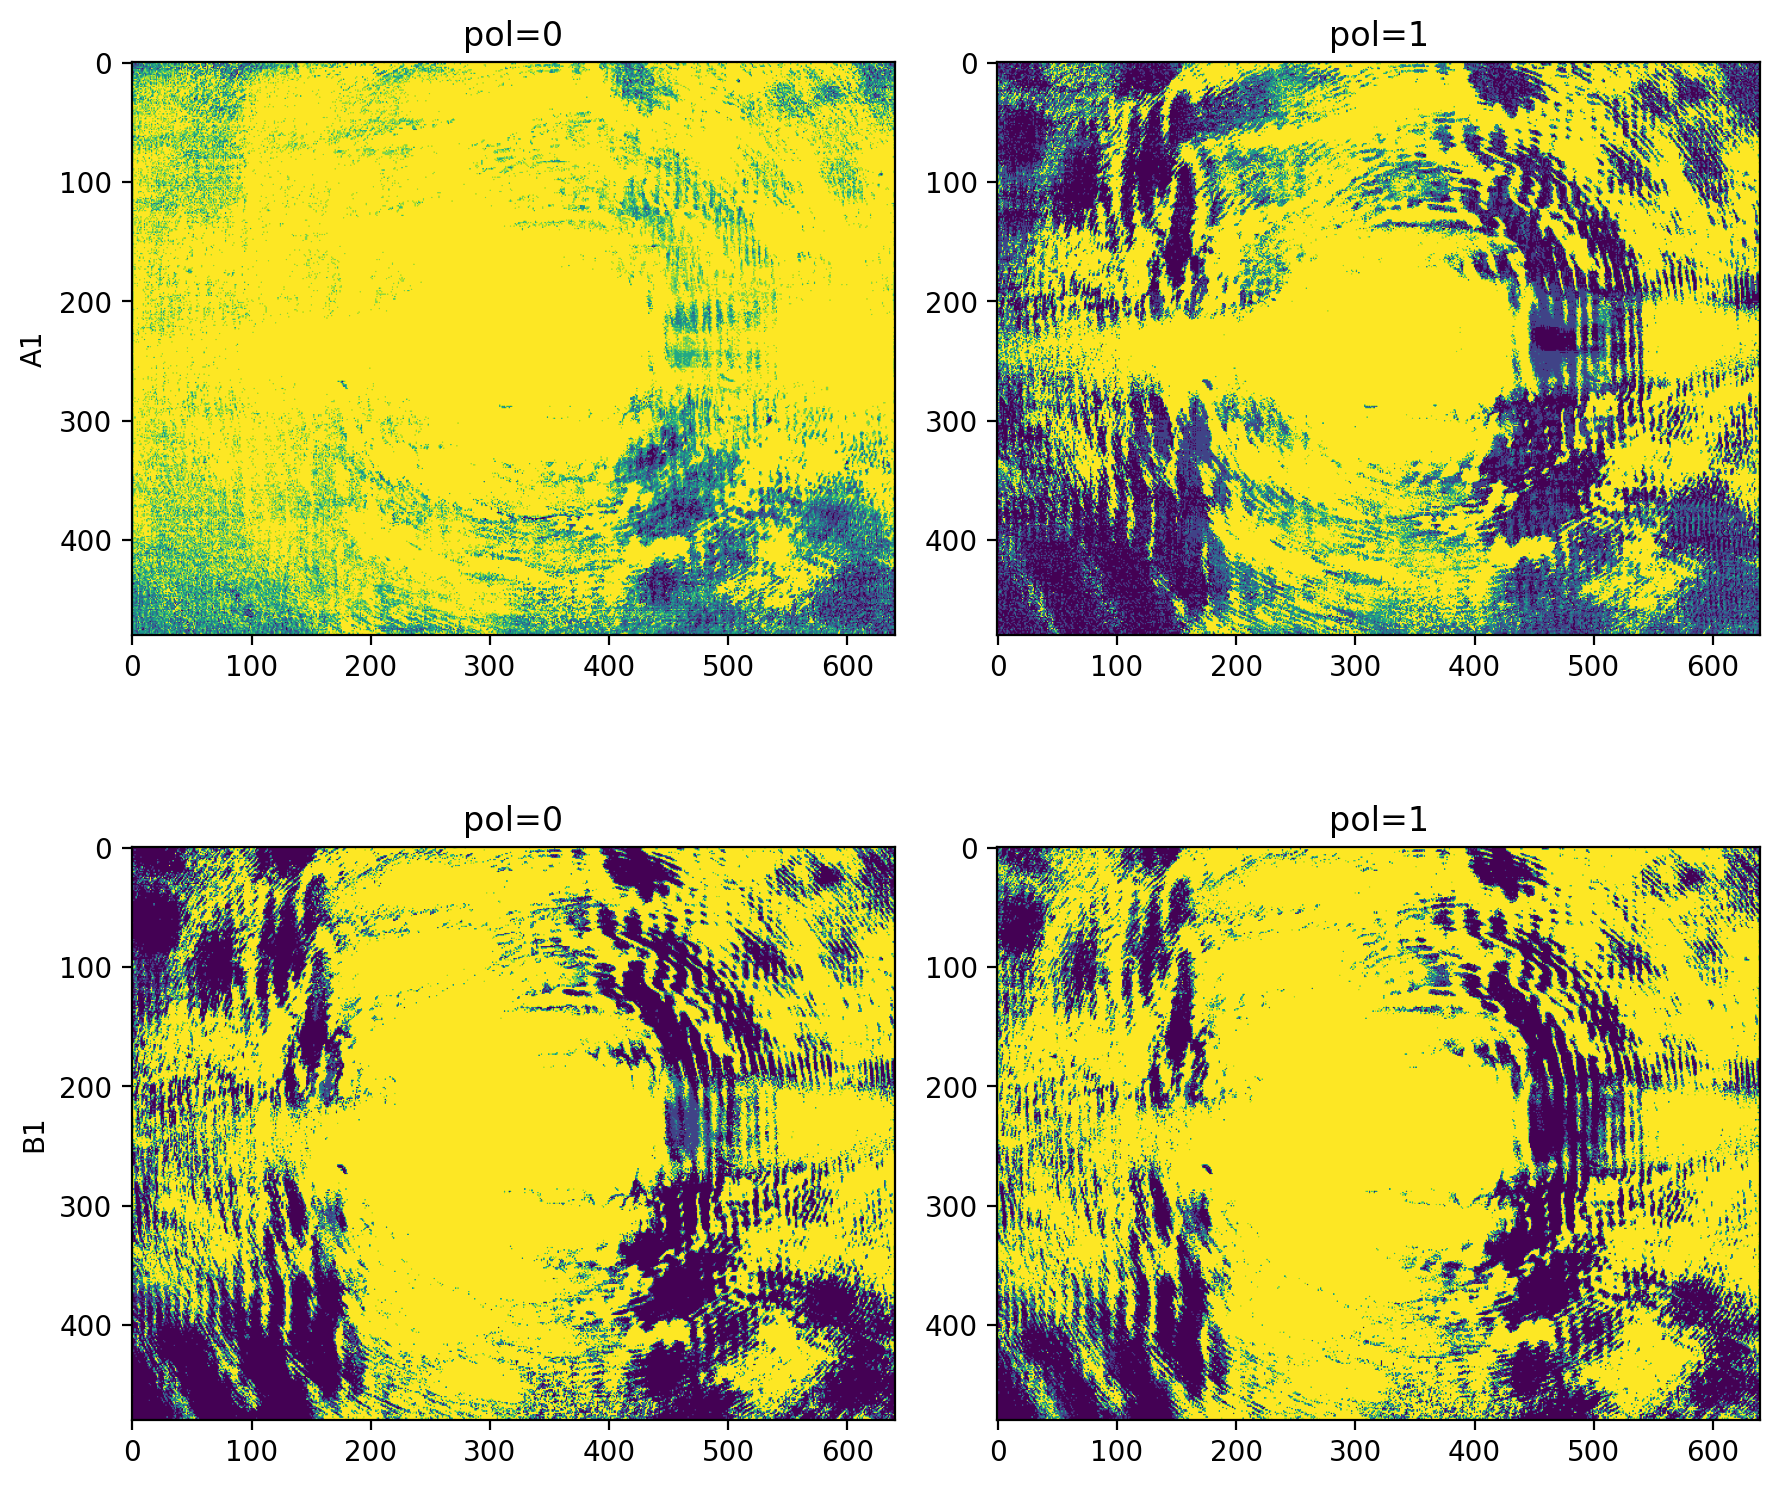

In [29]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(9, 8), dpi=200)
a1_hist = histogram_for_file(paths['a1'])
b1_hist = histogram_for_file(paths['b1'])
axs[0][0].set_ylabel('A1')
axs[1][0].set_ylabel('B1')
plot_histogram(a1_hist, pol=0, ax=axs[0][0])
plot_histogram(a1_hist, pol=1, ax=axs[0][1])
plot_histogram(b1_hist, pol=0, ax=axs[1][0])
plot_histogram(b1_hist, pol=1, ax=axs[1][1])
plt.tight_layout();

In [18]:
a = a1_hist[0,0,:,:]
print(f'A1, pol 0: µ={a.mean():.2f}')
a = b1_hist[0,0,:,:]
print(f'B1, pol 0: µ={a.mean():.2f}')

a = a1_hist[0,1,:,:]
print(f'A1, pol 1: µ={a.mean():.2f}')
a = b1_hist[0,1,:,:]
print(f'B1, pol 1: µ={a.mean():.2f}')

A1, pol 0: µ=0.89
A1, pol 1: µ=0.62
B1, pol 0: µ=0.68
B1, pol 1: µ=0.73


## Visualizing frames

In [19]:
fpath = paths['a1']
xypt = read_file_raw(fpath)

### 1ms frames

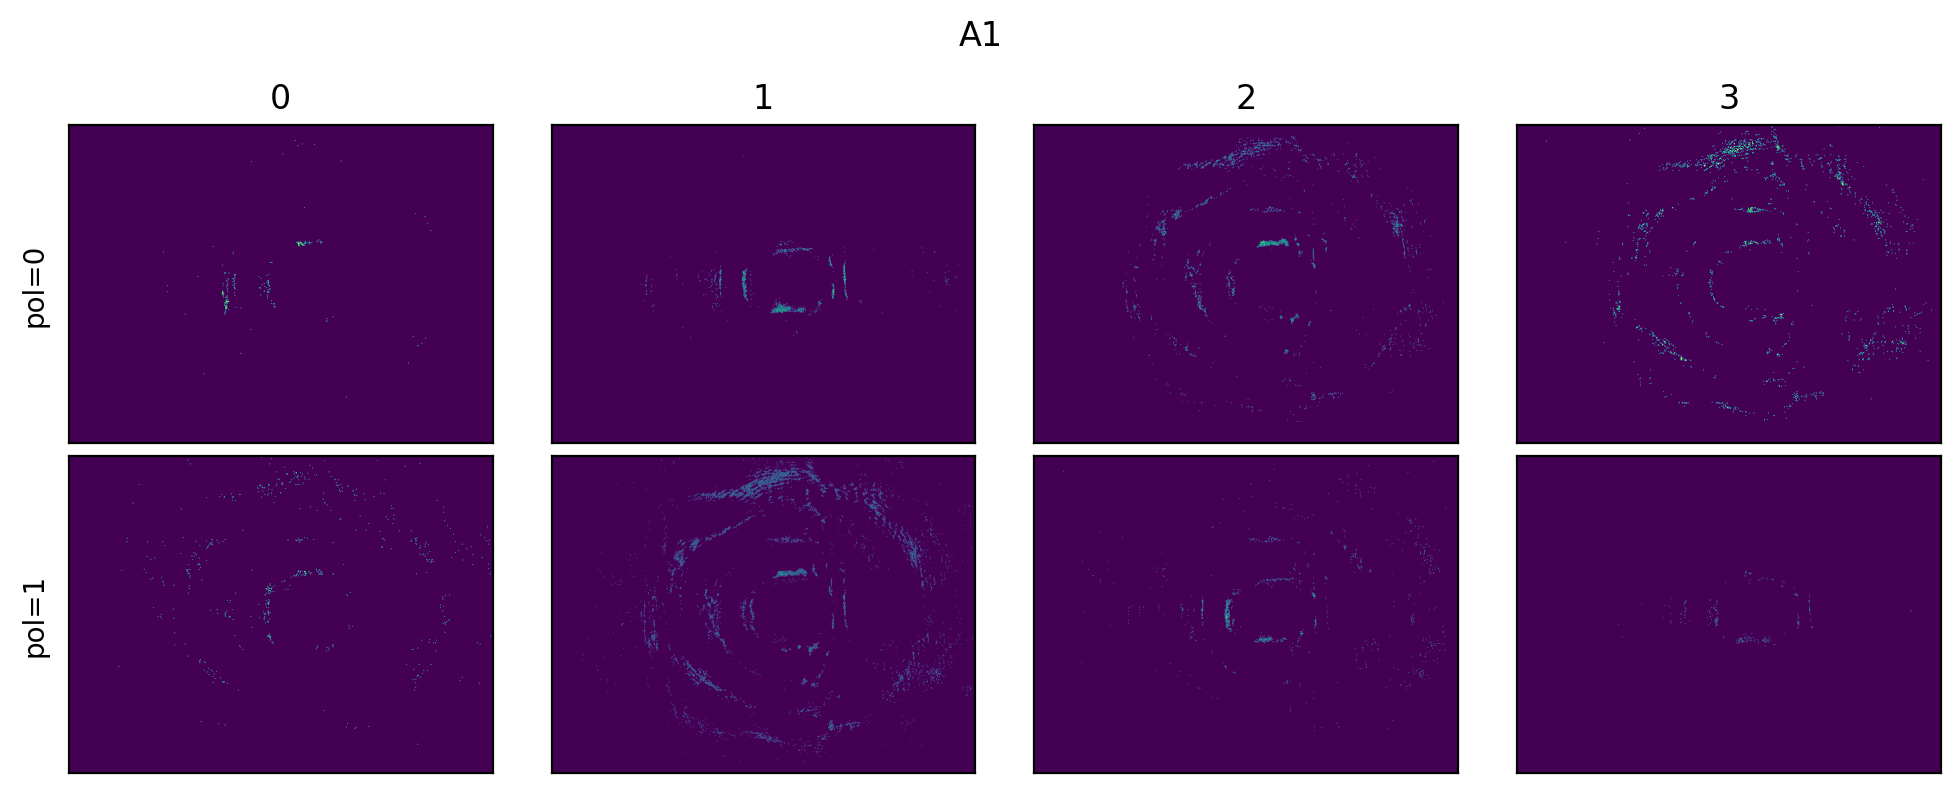

In [20]:
chunks = [read_file_chunk(paths['a1'], 1_000, 10_000_000 + i*1_000) for i in range(10)] # after 1s, read for 1ms
hists = [np.zeros((1, 2, 480, 640)) for _ in chunks]
for i in range(len(hists)):
    histo(chunks[i], hists[i], chunks[i]['t'].max() - chunks[i]['t'].min())
plot_hists(hists[:4], 'A1')

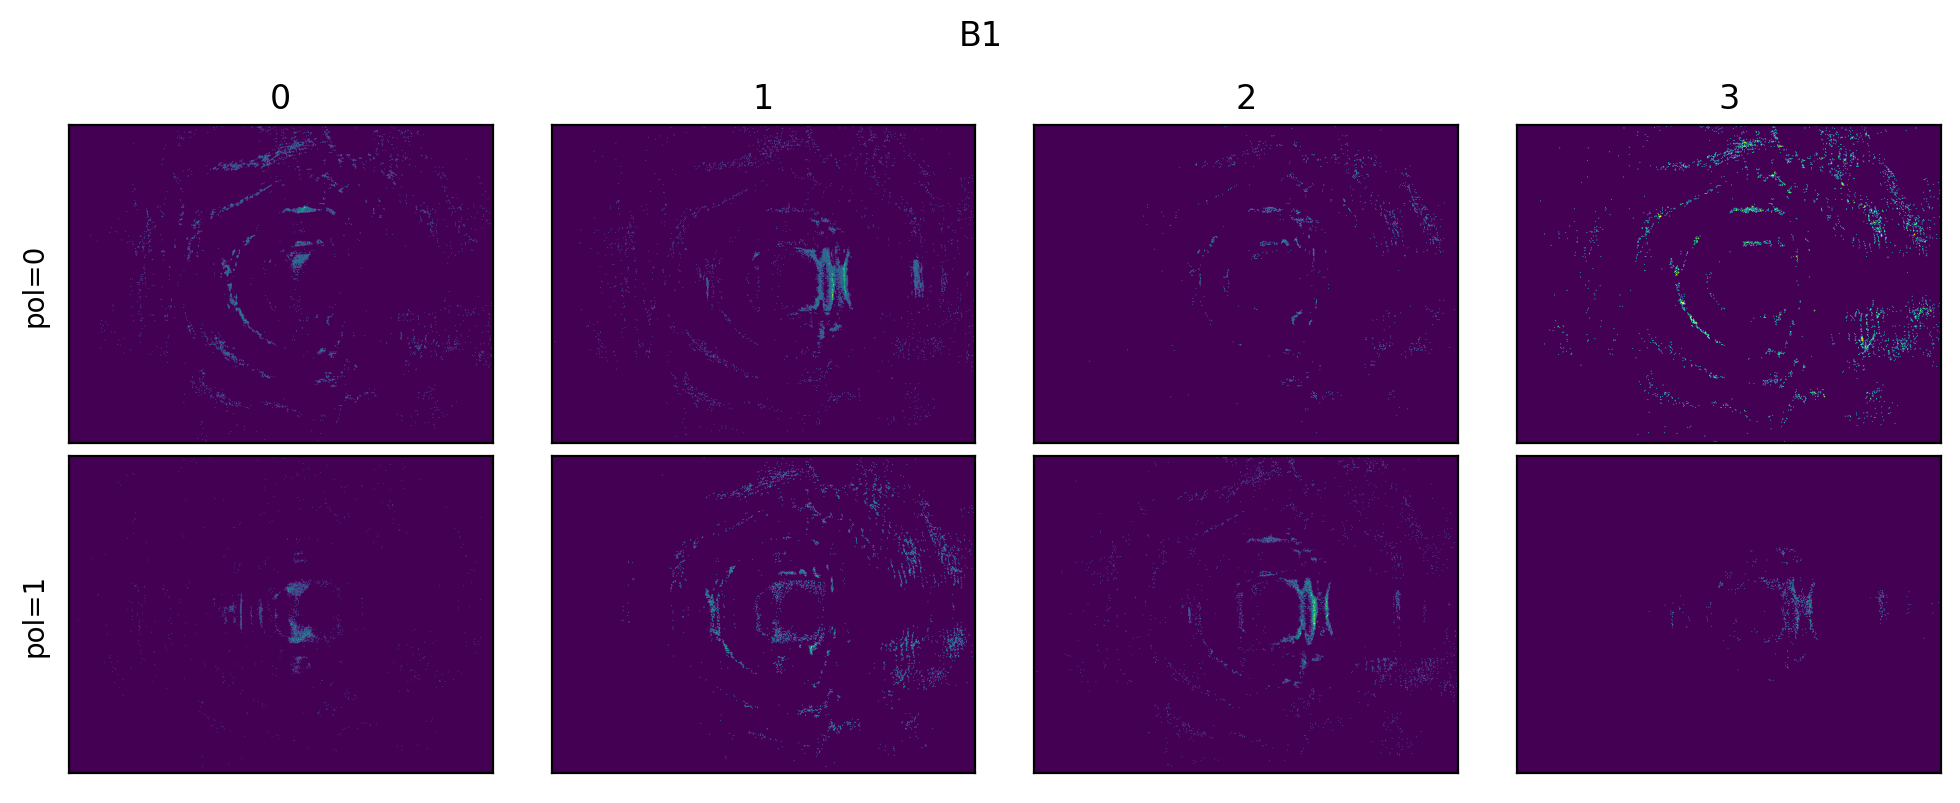

In [21]:
chunks = [read_file_chunk(paths['b1'], 1_000, 10_000_000 + i*1_000) for i in range(10)] # after 1s, read for 1ms
hists = [np.zeros((1, 2, 480, 640)) for _ in chunks]
for i in range(len(hists)):
    histo(chunks[i], hists[i], chunks[i]['t'].max() - chunks[i]['t'].min())
plot_hists(hists[:4], 'B1')

### 10ms frames

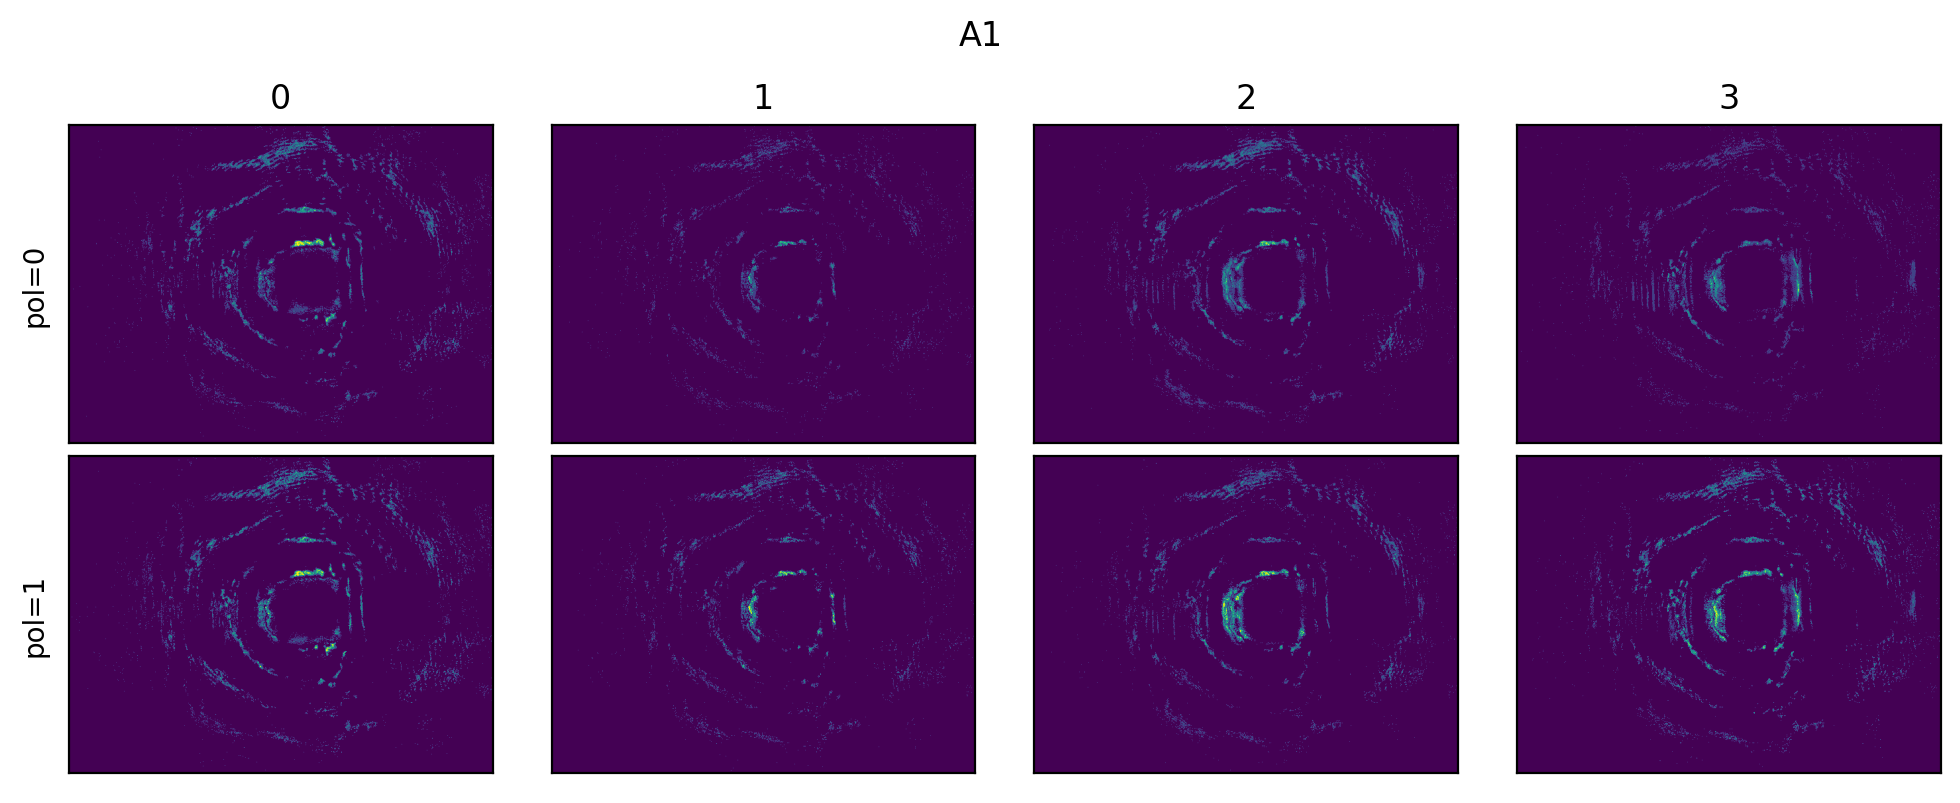

In [22]:
chunks = [read_file_chunk(paths['a1'], 10_000, 10_000_000 + i*10_000) for i in range(10)] # after 1s, read for 1ms
hists = [np.zeros((1, 2, 480, 640)) for _ in chunks]
for i in range(len(hists)):
    histo(chunks[i], hists[i], chunks[i]['t'].max() - chunks[i]['t'].min())
plot_hists(hists[:4], 'A1')

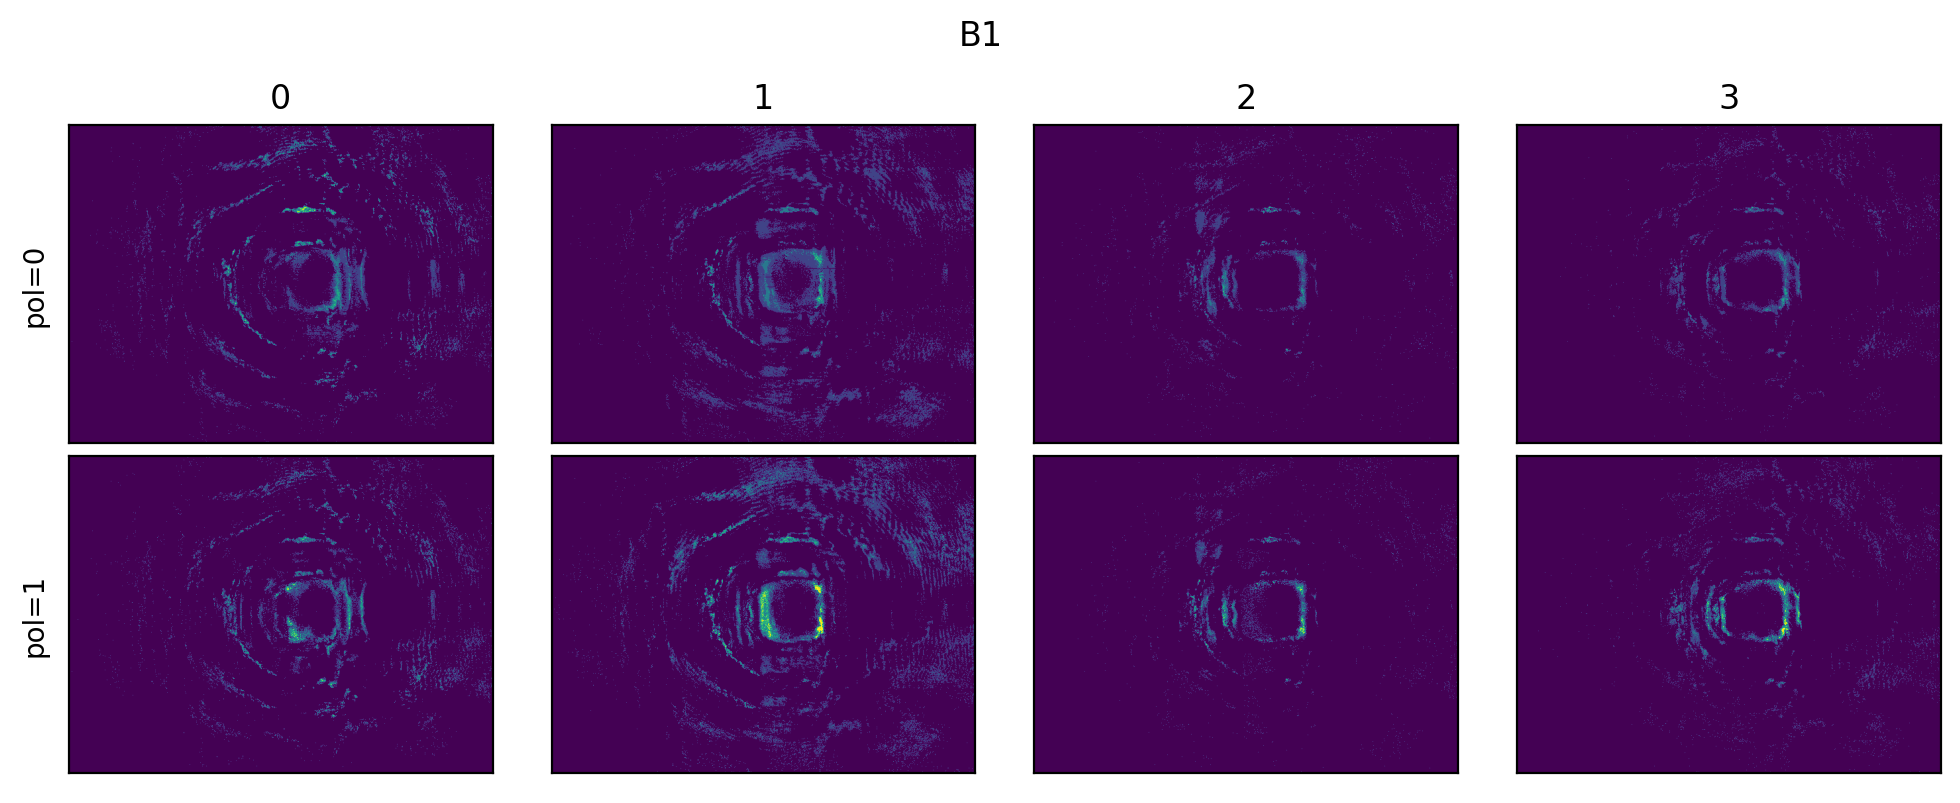

In [23]:
chunks = [read_file_chunk(paths['b1'], 10_000, 10_000_000 + i*10_000) for i in range(10)] # after 1s, read for 1ms
hists = [np.zeros((1, 2, 480, 640)) for _ in chunks]
for i in range(len(hists)):
    histo(chunks[i], hists[i], chunks[i]['t'].max() - chunks[i]['t'].min())
plot_hists(hists[:4], 'B1')

### 5ms frames

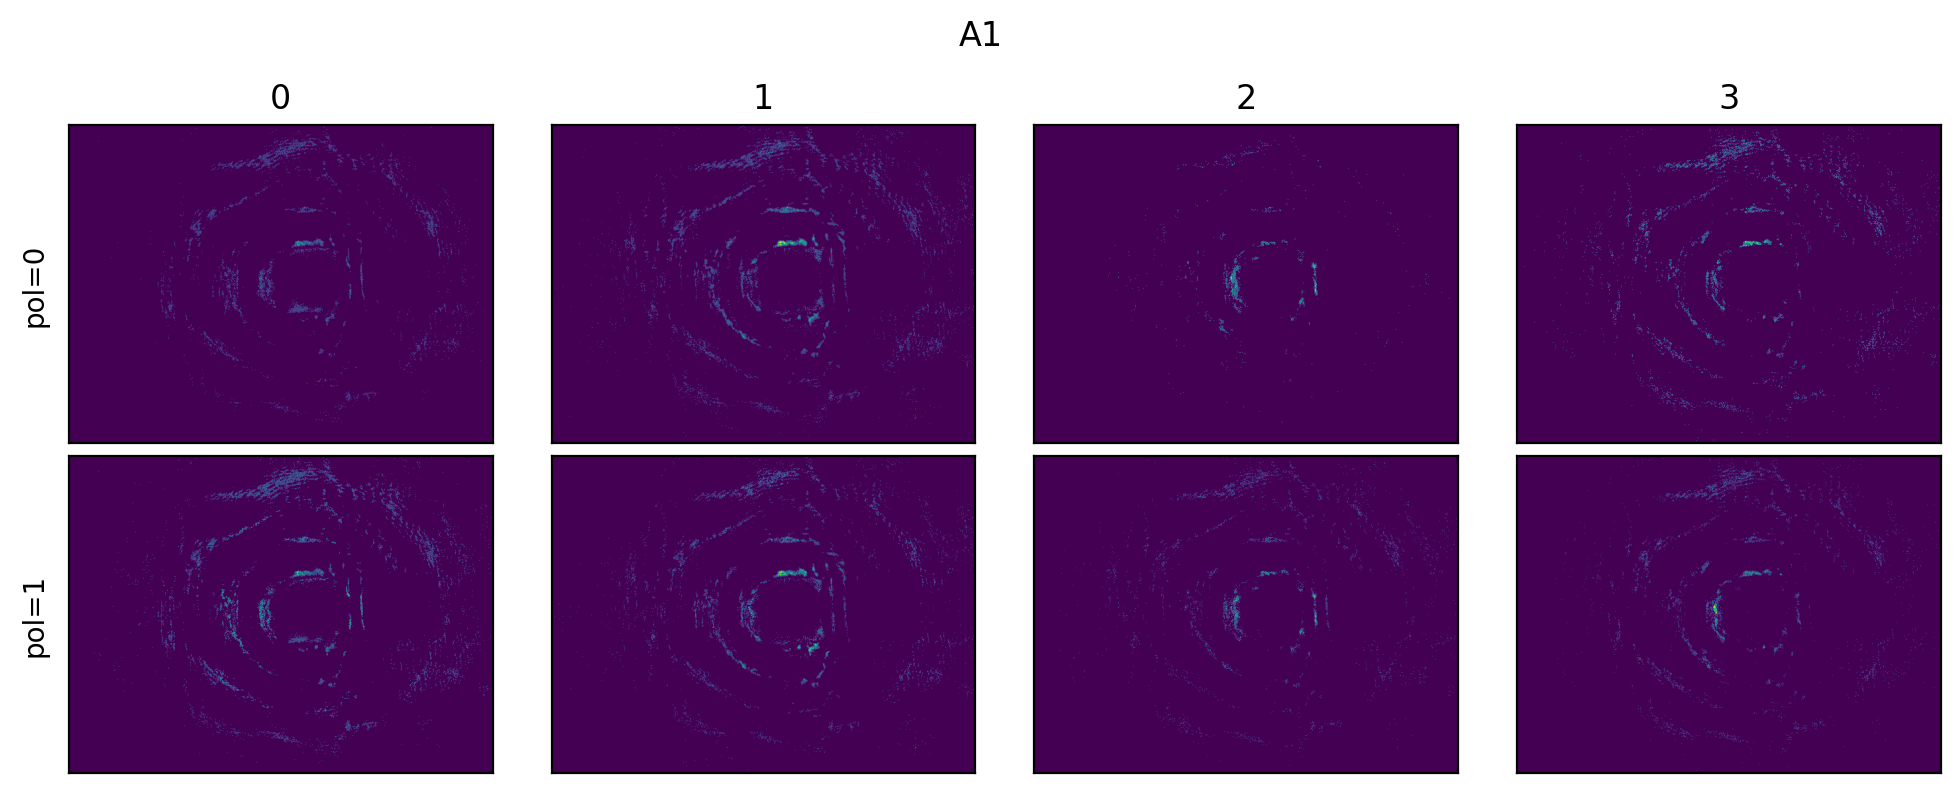

In [24]:
chunks = [read_file_chunk(paths['a1'], 5_000, 10_000_000 + i*5_000) for i in range(10)] # after 1s, read for 1ms
hists = [np.zeros((1, 2, 480, 640)) for _ in chunks]
for i in range(len(hists)):
    histo(chunks[i], hists[i], chunks[i]['t'].max() - chunks[i]['t'].min())
plot_hists(hists[:4], 'A1')

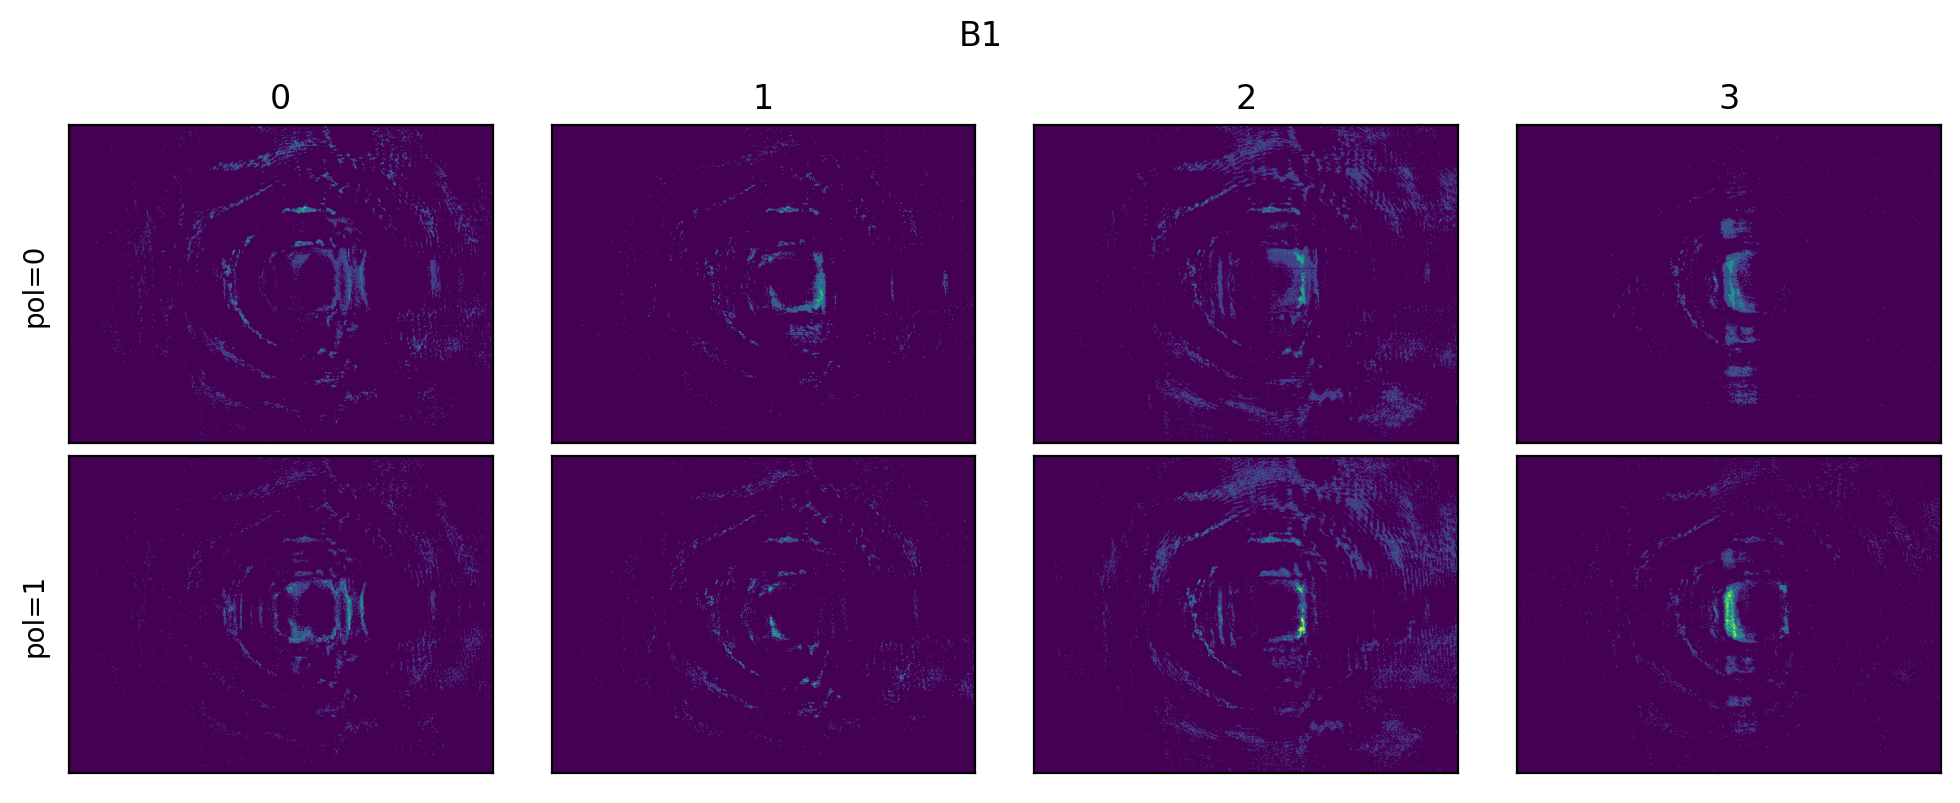

In [25]:
chunks = [read_file_chunk(paths['b1'], 5_000, 10_000_000 + i*5_000) for i in range(10)] # after 1s, read for 1ms
hists = [np.zeros((1, 2, 480, 640)) for _ in chunks]
for i in range(len(hists)):
    histo(chunks[i], hists[i], chunks[i]['t'].max() - chunks[i]['t'].min())
plot_hists(hists[:4], 'B1')